## 문제6) 이미지 분류
CIFAR-100 dataset 사용
특징
 - 클래스 수: 100개 (예: 사과, 버스, 산, 고래, 시계 등)
 - 샘플 수: 60,000장, 학습용(train): 50,000장, 테스트용(test): 10,000장
 - 이미지 크기: 32×32 RGB (작은 해상도)
 - 레이블 구조: 100개 fine labels (세부 클래스), 20개 coarse labels (상위 클래스 그룹)

기본 CNN으로도 학습 가능하지만, 성능을 높이려면
 - 데이터 증강(ImageDataGenerator / tf.image)
 - 전이학습(사전학습 모델)
 - 정규화/드롭아웃/배치정규화 등을 함께 쓰는 게 효과적

---
**전체 흐름 요약**

작업1 :  CIFAR-100 dataset  분류 모델 작성 (MovileNetV2 모델로 전이학습, 파인튜닝)

작업2 : 작성한 분류 모델 사용

웹 브라우저에서 이미지 선택 → 장고 웹서버에 저장 → 서버 내부에서 시각화로 확인(matplotlib) + 딥러닝 분류  → 클라이언트에 분류 결과만 반환하기

    작업2를 좀더 구체적으로 보면
        1) 클라이언트 : index.html에서 파일선택 버튼을 눌러 로컬 컴퓨터의 이미지 파일을 선택하고 화면에 선택된 이미지 출력: 분류결과요청 버튼 클릭 → AJAX 전송 (axios 모듈 사용)
        2) 서버(Django) : 수신된 이미지 파일 저장 → PIL + Matplotlib(imshow)으로 확인 → 딥러닝 분류 모델로 추론: 응답(JSON): 분류 결과만 반환(예 : bus)
        3) 클라이언트 : 기존 이미지 아래에 이미지 분류 결과 문자열을 화면에 출력

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.datasets import cifar100

In [2]:
# 데이터 준비
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# label(class) 원핫 처리
NUM_CLASSES = 100
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

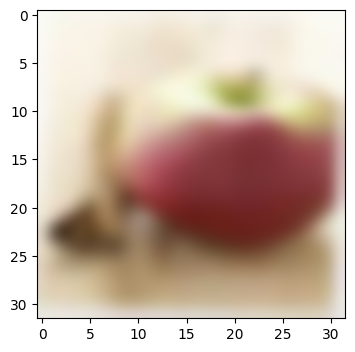

In [3]:
# 출력 확인
plt.figure(figsize=(12, 4))
plt.imshow(x_train[2], interpolation='bicubic') # interpolation='bicubic'
plt.show()
plt.close()

In [ ]:
# 전처리
IMG_SIZE = (160, 160)  # 96, 128, 160, 192, 224
BATCH_SIZE = 32

# 전이학습 : MobileNetV2 불러오기
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (160, 160, 3),
    include_top = False,
    weights = 'imagenet'
)

base_model.trainable = False

# 데이터 증강
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# 모델 생성
inputs = tf.keras.layers.Input(shape=x_train.shape[1:])
net = tf.keras.layers.Resizing(160, 160)(inputs)
net = base_model(net, training=False)
net = tf.keras.layers.GlobalAveragePooling2D()(net)
net = tf.keras.layers.Dense(128, activation='leaky_relu')(net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Dropout(0.3)(net)
outputs = tf.keras.layers.Dense(100, activation='softmax')(net)

model = tf.keras.Model(inputs, outputs)

# model.summary()

# 학습
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Callbacks
CALLBACK = [
    tf.keras.callbacks.ModelCheckpoint('tf45_ex6.keras', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

history = model.fit(x_train, y_train, epochs=100, batch_size=BATCH_SIZE, validation_split=0.3, verbose=2, callbacks=CALLBACK)

# 평가
loss, acc = model.evaluate(x_test, y_test)
print(f"acc : {acc:.4f}")
print(f"loss : {loss:.4f}")

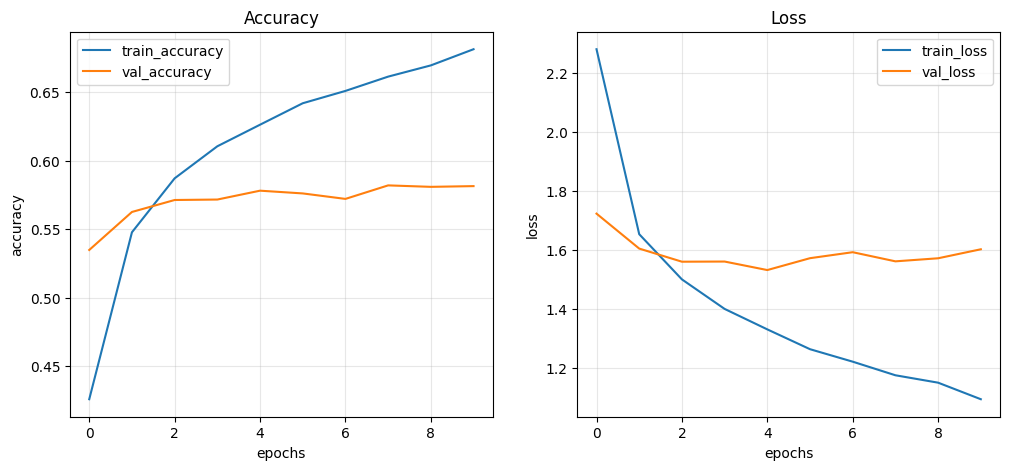

In [45]:
# 시각화 : 학습 곡선 ( 정확도 / 손실 )
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

In [33]:
# Fine Tuning 미세조정
print(f"total layers : {len(base_model.layers)}") # 154


fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


# 미세 조정 후 모델 재학습
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy'])

CALLBACK = [
    tf.keras.callbacks.ModelCheckpoint('tf45_ex6_mac.keras', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(x_train, y_train, epochs=100, batch_size=BATCH_SIZE, validation_split=0.2, verbose=2, callbacks=CALLBACK)

# 미세조정 평가
loss, acc = model.evaluate(x_test, y_test)
print(f"acc : {acc:.4f}")
print(f"loss : {loss:.4f}")

NameError: name 'base_model' is not defined

In [ ]:
model = tf.keras.models.load_model('/Users/bunny/Downloads/MobileTranserModel.keras')
# /Users/bunny/Downloads/tf45_ex6_6092.keras   cifar100_mobilenetv2.h5
model.summary()

loss, acc = model.evaluate(x_test,y_test, verbose=0)
print(f"분류 정확도 : {acc:.4f}")
print(f"loss : {loss:.4f}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_4 (Resizing)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,789,614 (10.64 MB)

 Trainable params: 177,124 (691.89 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

 Optimizer params: 354,250 (1.35 MB)

ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 100), output.shape=(None, 100)

In [10]:
CLASSES = np.array([
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard',
    'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushrooms', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree',
    'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy',
    'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail',
    'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train',
    'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf',
    'woman', 'worm'
])

In [11]:
pred = model.predict(x_test[:20])
pred_indices = np.argmax(pred, axis=-1)
pred_cla = CLASSES[pred_indices]

actual_indices = np.argmax(y_test[:20], axis=-1)
actual_cla = CLASSES[actual_indices]

print(pred_indices)
print(actual_indices)
print('예측값: ', pred_cla)
print('실제값: ', actual_cla)
print('분류 실패 수: ', np.sum(pred_indices != actual_indices))

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "mobilenetv2_1.00_160" is incompatible with the layer: expected shape=(None, 160, 160, 3), found shape=(20, 32, 32, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(20, 32, 32, 3), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [9]:
from tensorflow.keras.datasets import cifar100
(_, _), (_, y_test) = cifar100.load_data(label_mode='fine')
print(np.unique(y_test))  # 라벨 인덱스가 0~99인지 확인

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [29]:
IMG_PATH = Path('/Users/bunny/Documents/hyundairotem_aimodel/python_analysis/tensorflow/cat_dog')
# /Users/bunny/Documents/hyundairotem_aimodel/python_analysis/tensorflow/cat_dog
target_height, target_width = model.input_shape[1:3]

image_files = []
if IMG_PATH.exists():
    for pattern in ('*.jpg', '*.jpeg', '*.png', '*.bmp'):
        image_files.extend(sorted(IMG_PATH.glob(pattern)))

if image_files:
    def load_external_image(path: Path) -> tf.Tensor:
        image_bytes = tf.io.read_file(str(path))
        image = tf.image.decode_image(image_bytes, channels=3)
        image = tf.image.resize(image, (target_height, target_width))
        image = tf.cast(image, tf.float32) / 255.0
        return image

    external_images = tf.stack([load_external_image(path) for path in image_files], axis=0)
    external_pred = model.predict(external_images)
    external_indices = np.argmax(external_pred, axis=-1)
    external_classes = CLASSES[external_indices]

    print('\nExternal image predictions:')
    for path, label, idx in zip(image_files, external_classes, external_indices):
        print(f"{path.name}: {label} (class #{idx})")
else:
    print(f'No image files found in {IMG_PATH}')


'''
apple.jpg: rose (class #70)
myimg.jpg: tank (class #85)
myimg2.jpg: skunk (class #75)
myimg3.jpg: leopard (class #42)
myimg4.jpg: leopard (class #42)
rabbit.jpg: rabbit (class #65)
sunflower.jpg: sunflower (class #82)
table.jpg: chair (class #20)
tank.jpg: tank (class #85)
hamster.jpeg: hamster (class #36)
image4.jpeg: camel (class #15)
lawning_.jpeg: motorcycle (class #48)
man.jpeg: man (class #46)
oak.jpeg: lamp (class #40)
'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

External image predictions:
apple.jpg: rose (class #70)
myimg.jpg: butterfly (class #14)
myimg2.jpg: skunk (class #75)
myimg3.jpg: leopard (class #42)
myimg4.jpg: raccoon (class #66)
rabbit.jpg: rabbit (class #65)
sunflower.jpg: sunflower (class #82)
table.jpg: chair (class #20)
tank.jpg: tank (class #85)
hamster.jpeg: hamster (class #36)
image4.jpeg: camel (class #15)
lawning_.jpeg: leopard (class #42)
man.jpeg: man (class #46)
oak.jpeg: lamp (class #40)


'\napple.jpg: rose (class #70)\nmyimg.jpg: tank (class #85)\nmyimg2.jpg: skunk (class #75)\nmyimg3.jpg: leopard (class #42)\nmyimg4.jpg: leopard (class #42)\nrabbit.jpg: rabbit (class #65)\nsunflower.jpg: sunflower (class #82)\ntable.jpg: chair (class #20)\ntank.jpg: tank (class #85)\nhamster.jpeg: hamster (class #36)\nimage4.jpeg: camel (class #15)\nlawning_.jpeg: motorcycle (class #48)\nman.jpeg: man (class #46)\noak.jpeg: lamp (class #40)\n'